In [7]:
# =============================================================================
# CELL: Data Pipeline Status Check v2 (MySQL Compatibility Fix)
#
# PURPOSE:
# To dynamically query the database and retrieve the last 5 available
# trading days from the `equity_history` table.
#
# VERSION 2.0 CORRECTIONS:
# - Rewrote the SQL query to avoid the "LIMIT & IN" subquery error,
#   ensuring compatibility with older MySQL versions.
# =============================================================================
import pandas as pd
from sqlalchemy import create_engine, text
from pathlib import Path
import yaml
from datetime import datetime

print("="*70)
print("📊 Real-Time Data Pipeline Status Check (v2 - MySQL Compatibility Fix)")
print("="*70)

# --- 1. Establish Database Connection (Standardized Logic) ---
try:
    project_root = Path.cwd()
    while not (project_root / 'config').exists():
        if project_root.parent == project_root:
            raise FileNotFoundError("Could not find project root.")
        project_root = project_root.parent
    
    config_path = project_root / 'config' / 'database.yml'
    with open(config_path, 'r') as f:
        db_config = yaml.safe_load(f)['production']
    
    engine = create_engine(
        f"mysql+pymysql://{db_config['username']}:{db_config['password']}@"
        f"{db_config['host']}/{db_config['schema_name']}"
    )
    print(f"✅ Connection to '{db_config['schema_name']}' established.")
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    raise

# --- 2. Construct and Execute the COMPATIBLE Query ---
print("\nQuerying for the last 5 available trading days (compatible method)...")

# <<< CRITICAL FIX: Two-step query for compatibility >>>
try:
    with engine.connect() as connection:
        # Step 1: Get the 5 most recent distinct dates first.
        latest_dates_query = text("""
            SELECT DISTINCT date 
            FROM equity_history 
            ORDER BY date DESC 
            LIMIT 5
        """)
        latest_dates_result = connection.execute(latest_dates_query).fetchall()
        latest_dates_list = [row[0] for row in latest_dates_result]

        if not latest_dates_list:
            latest_days_df = pd.DataFrame(columns=['date', 'ticker_count'])
        else:
            # Step 2: Use these specific dates in the main query.
            # This avoids the unsupported subquery structure.
            main_query = text("""
                SELECT 
                    date,
                    COUNT(ticker) as ticker_count
                FROM 
                    equity_history
                WHERE 
                    date IN :dates_list
                GROUP BY 
                    date
                ORDER BY 
                    date DESC;
            """)
            latest_days_df = pd.read_sql(main_query, connection, params={'dates_list': latest_dates_list})

    print("✅ Query executed successfully.")
    
    # --- 3. Display and Analyze the Results ---
    print("\n" + "="*70)
    print("📈 LATEST 5 AVAILABLE TRADING DAYS IN `equity_history`")
    print("="*70)
    
    if not latest_days_df.empty:
        latest_available_date = pd.to_datetime(latest_days_df['date'].max())
        today = pd.Timestamp.now().normalize()
        lag = (today - latest_available_date).days
        
        latest_days_df['Day_of_Week'] = pd.to_datetime(latest_days_df['date']).dt.day_name()
        
        print(f"Today's Date:         {today.date()}")
        print(f"Latest Available Data:  {latest_available_date.date()}")
        print(f"Current Data Lag:       {lag} calendar day(s)")
        
        print("\n--- Data Details ---")
        display(latest_days_df)
        
        print("\n--- ASSESSMENT ---")
        if lag <= 2:
            print("✅ EXCELLENT: Data pipeline is up-to-date (T-1 or better).")
        elif lag <= 4:
            print("⚠️  WARNING: Data pipeline has a minor lag of a few days.")
            print("   This explains the date discrepancy observed in the momentum calculation.")
        else:
            print("❌ CRITICAL: Data pipeline has a significant lag (>4 days). Needs investigation.")
        
    else:
        print("❌ No data returned from the query. The `equity_history` table may be empty or inaccessible.")

except Exception as e:
    print(f"❌ Query failed: {e}")

📊 Real-Time Data Pipeline Status Check (v2 - MySQL Compatibility Fix)
✅ Connection to 'alphabeta' established.

Querying for the last 5 available trading days (compatible method)...
✅ Query executed successfully.

📈 LATEST 5 AVAILABLE TRADING DAYS IN `equity_history`
Today's Date:         2025-07-25
Latest Available Data:  2025-07-25
Current Data Lag:       0 calendar day(s)

--- Data Details ---


,date,ticker_count,Day_of_Week
0,2025-07-25,716,Friday
1,2025-07-24,722,Thursday
2,2025-07-22,715,Tuesday
3,2025-07-18,715,Friday
4,2025-07-16,715,Wednesday



--- ASSESSMENT ---
✅ EXCELLENT: Data pipeline is up-to-date (T-1 or better).


🚀 Factor Calculation Deep Dive & Transparency Audit (v4 - Final)
✅ Project root identified at: /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project
✅ Successfully imported QVMEngineV2Enhanced.

🔌 Establishing database connection and initializing engine...
✅ Database and Engine initialized successfully.

🎯 Analysis Date: 2025-07-25
🎯 Test Universe: ['FPT', 'VCB', 'SSI', 'NLG']

📊 STEP 1: Loading Raw Data Ingredients
Loading Point-in-Time Fundamentals...
--- Raw Fundamental Data (TTM) ---


ticker,VCB,SSI,FPT,NLG
year,2025.0,2025.0,2025.0,2025.0
quarter,1.0,1.0,1.0,1.0
NetProfit_TTM,"33,968.9B","2,924.8B","9,855.4B","1,556.6B"
AvgTotalEquity,"189,799.3B","25,501.1B","34,704.2B","13,803.4B"
Revenue_TTM,N/A,N/A,"64,814.0B","8,282.6B"



Loading Point-in-Time Market Data...
NOTE: Latest available trading_date is 2025-07-24, which is correct for an analysis on 2025-07-25.
--- Raw Market Data ---


ticker,FPT,NLG,SSI,VCB
price,"111,100","40,450","32,000","62,100"
market_cap,"189,262.1B","15,576.3B","63,099.9B","518,887.4B"



Loading Historical Price Data for Momentum...
Loaded 1143 price records from 2024-05-27 to 2025-07-24.
NOTE: The latest price data used is correctly from the day before the analysis date.

🔬 STEP 2: Step-by-Step Factor Calculation (Pre-Normalization)

--- Analyzing Ticker: FPT (Technology) ---

[A] Quality Factor Calculation:
  1. ROAE = NetProfit_TTM / AvgTotalEquity
     = 9,855.4B / 34,704.2B = 0.2840

[B] Value Factor Calculation:
  1. Earnings Yield (E/P) = 1 / (Market Cap / NetProfit_TTM)
     = 1 / (189,262.1B / 9,855.4B) = 0.0521
  2. Book-to-Price (B/P) = 1 / (Market Cap / Point-in-Time Equity)
     = 1 / (189,262.1B / 37,896.7B) = 0.2002

[C] Momentum Factor Calculation:
  - 1M Return (2025-05-25 to 2025-06-25) = 0.68%


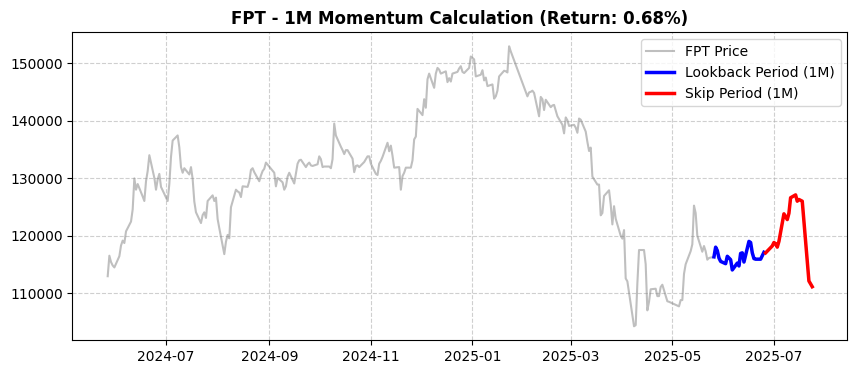

  - 3M Return (2025-03-25 to 2025-06-25) = -6.64%


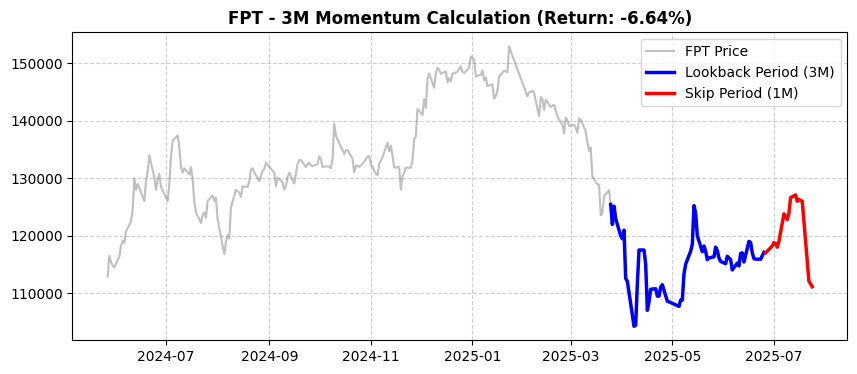

  - 6M Return (2024-12-25 to 2025-06-25) = -21.68%


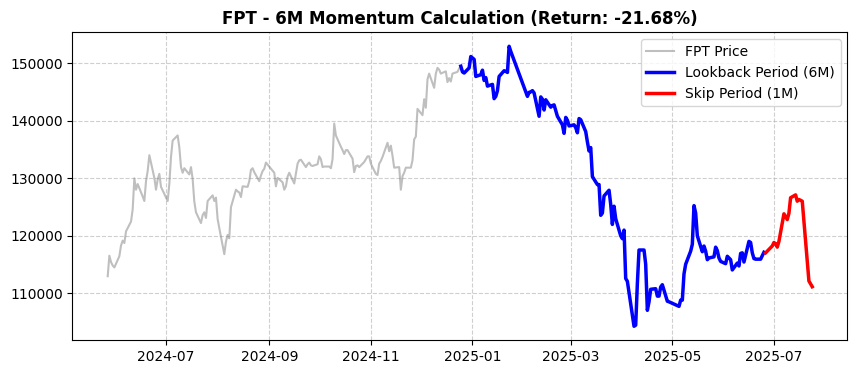

  - 12M Return (2024-06-25 to 2025-06-25) = -8.52%


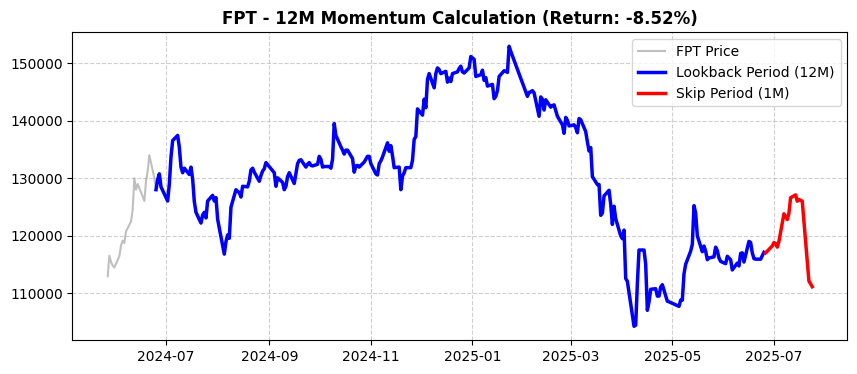

  --> Weighted Momentum Score = -0.1062

--- Analyzing Ticker: VCB (Banking) ---

[A] Quality Factor Calculation:
  1. ROAE = NetProfit_TTM / AvgTotalEquity
     = 33,968.9B / 189,799.3B = 0.1790

[B] Value Factor Calculation:
  1. Earnings Yield (E/P) = 1 / (Market Cap / NetProfit_TTM)
     = 1 / (518,887.4B / 33,968.9B) = 0.0655
  2. Book-to-Price (B/P) = 1 / (Market Cap / Point-in-Time Equity)
     = 1 / (518,887.4B / 204,839.9B) = 0.3948

[C] Momentum Factor Calculation:
  - 1M Return (2025-05-25 to 2025-06-25) = -0.70%


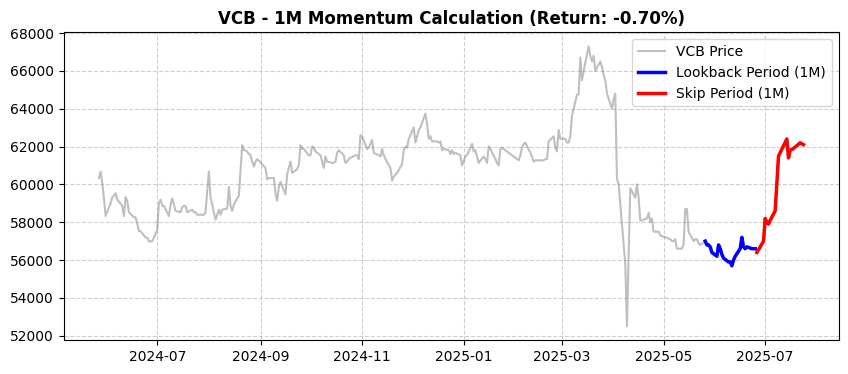

  - 3M Return (2025-03-25 to 2025-06-25) = -14.50%


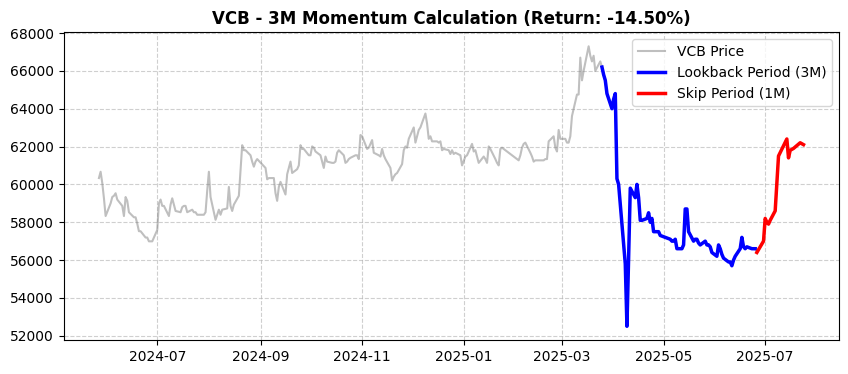

  - 6M Return (2024-12-25 to 2025-06-25) = -8.42%


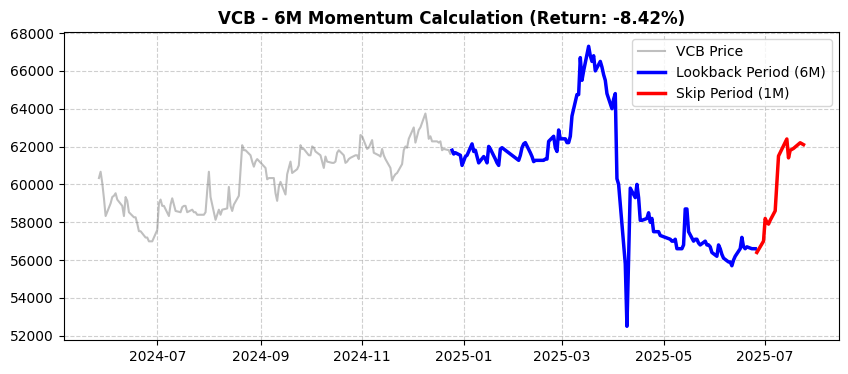

  - 12M Return (2024-06-25 to 2025-06-25) = -1.03%


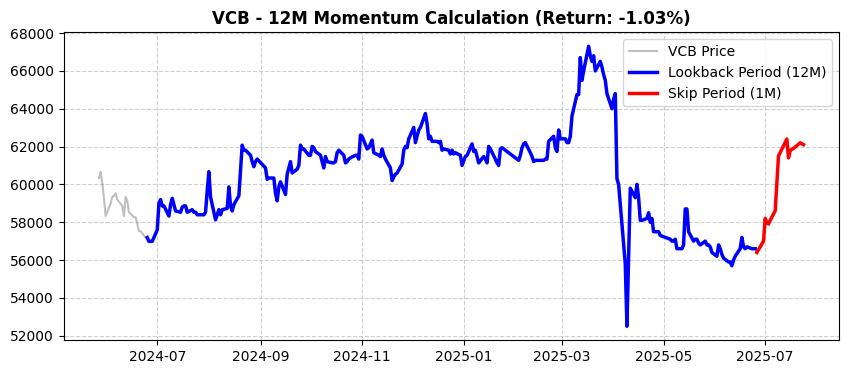

  --> Weighted Momentum Score = -0.0657

--- Analyzing Ticker: SSI (Securities) ---

[A] Quality Factor Calculation:
  1. ROAE = NetProfit_TTM / AvgTotalEquity
     = 2,924.8B / 25,501.1B = 0.1147

[B] Value Factor Calculation:
  1. Earnings Yield (E/P) = 1 / (Market Cap / NetProfit_TTM)
     = 1 / (63,099.9B / 2,924.8B) = 0.0464
  2. Book-to-Price (B/P) = 1 / (Market Cap / Point-in-Time Equity)
     = 1 / (63,099.9B / 27,703.4B) = 0.4390

[C] Momentum Factor Calculation:
  - 1M Return (2025-05-25 to 2025-06-25) = 3.81%


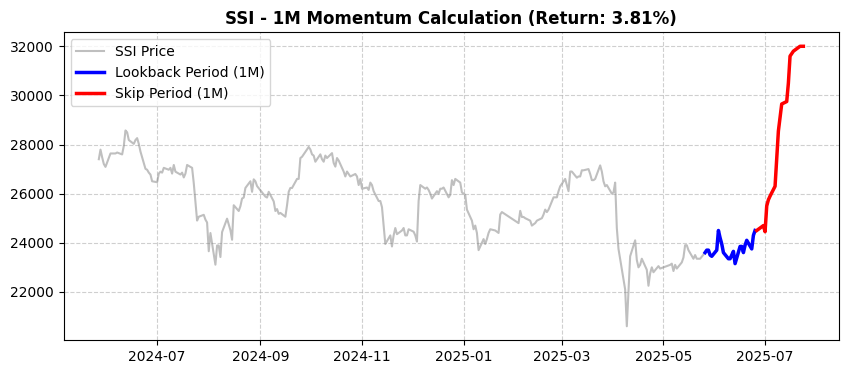

  - 3M Return (2025-03-25 to 2025-06-25) = -8.92%


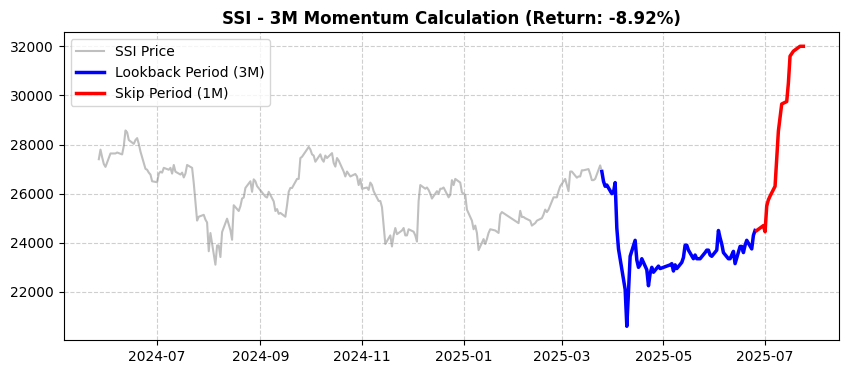

  - 6M Return (2024-12-25 to 2025-06-25) = -7.72%


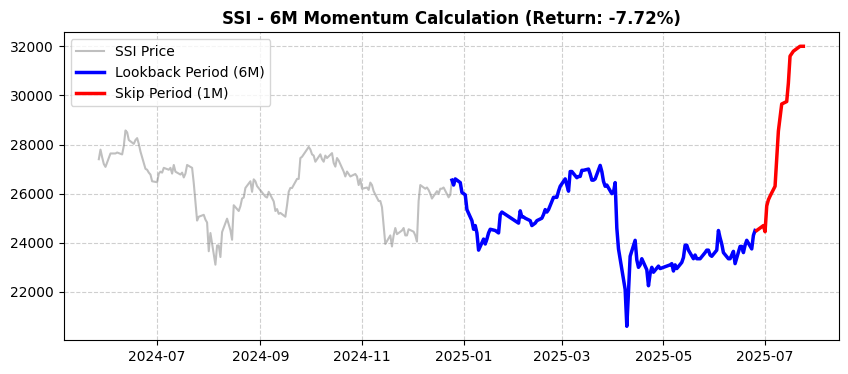

  - 12M Return (2024-06-25 to 2025-06-25) = -9.17%


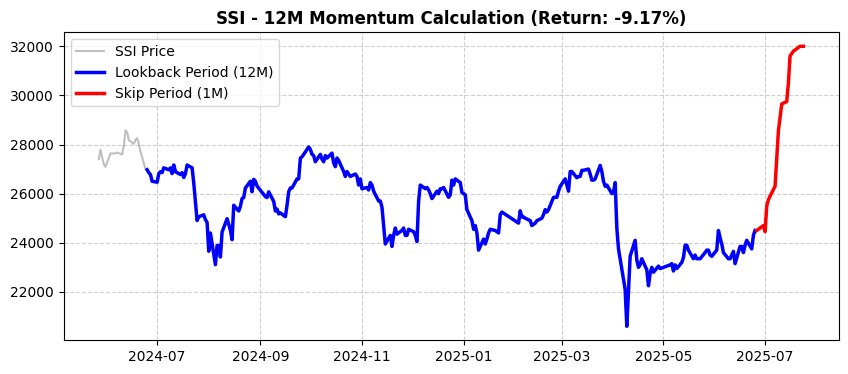

  --> Weighted Momentum Score = -0.0672

--- Analyzing Ticker: NLG (Real Estate) ---

[A] Quality Factor Calculation:
  1. ROAE = NetProfit_TTM / AvgTotalEquity
     = 1,556.6B / 13,803.4B = 0.1128

[B] Value Factor Calculation:
  1. Earnings Yield (E/P) = 1 / (Market Cap / NetProfit_TTM)
     = 1 / (15,576.3B / 1,556.6B) = 0.0999
  2. Book-to-Price (B/P) = 1 / (Market Cap / Point-in-Time Equity)
     = 1 / (15,576.3B / 14,519.4B) = 0.9321

[C] Momentum Factor Calculation:
  - 1M Return (2025-05-25 to 2025-06-25) = 5.90%


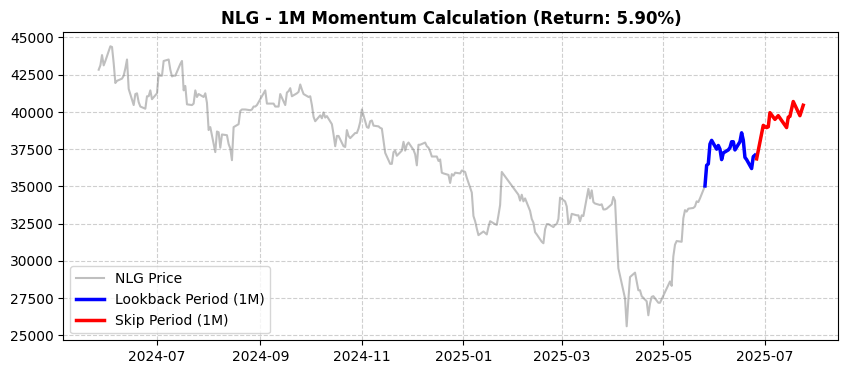

  - 3M Return (2025-03-25 to 2025-06-25) = 9.76%


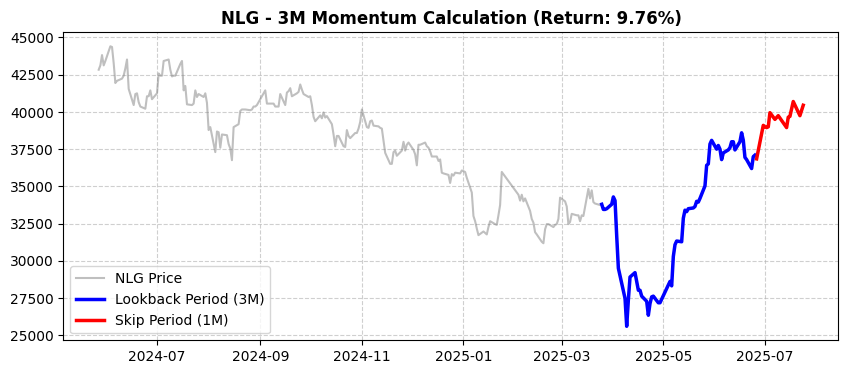

  - 6M Return (2024-12-25 to 2025-06-25) = 3.56%


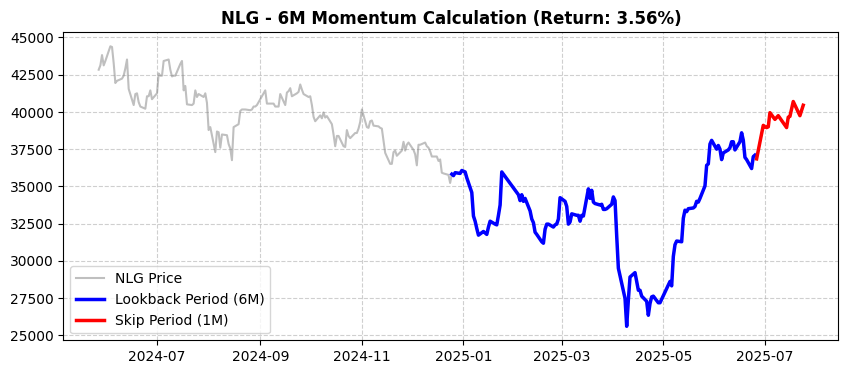

  - 12M Return (2024-06-25 to 2025-06-25) = -9.63%


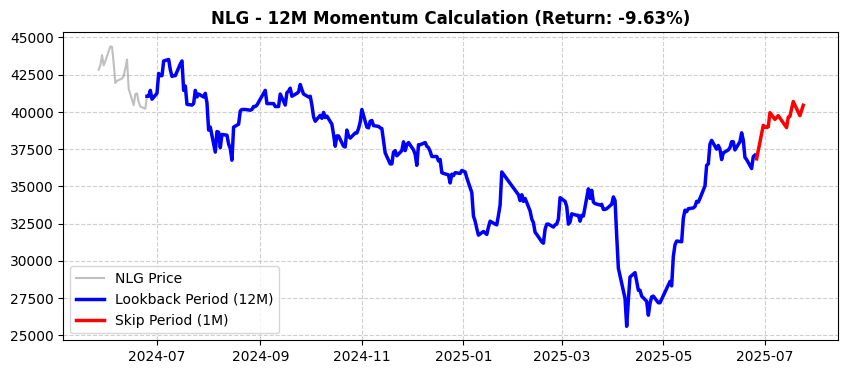

  --> Weighted Momentum Score = 0.0151

📋 STEP 3: Final Pre-Normalization Factor Scores


,Ticker,Sector,Quality_Raw,Value_Raw,Momentum_Raw
0,FPT,Technology,0.283982,0.126153,-0.106178
1,VCB,Banking,0.178973,0.230116,-0.065674
2,SSI,Securities,0.114693,0.242696,-0.067248
3,NLG,Real Estate,0.112766,0.516039,0.015052


In [9]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# NOTEBOOK: 04_factor_calculation_deep_dive_v4.ipynb (Corrected Formatting & Bug Fix)
#
# PURPOSE:
# To provide a complete, transparent, step-by-step audit of the
# QVMEngineV2Enhanced's calculation logic as of the current date.
#
# VERSION 4.0 CORRECTIONS:
# - ANALYSIS_DATE updated to July 25, 2025.
# - Data display now uses BILLIONS (B) of VND format for clarity.
# - Fixed `AttributeError` on `trading_date` display.
# - Maintained corrected momentum query logic from v3.
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

import pandas as pd
import numpy as np
from pathlib import Path
import sys
import yaml
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. ENVIRONMENT SETUP ---
print("="*70)
print("🚀 Factor Calculation Deep Dive & Transparency Audit (v4 - Final)")
print("="*70)

try:
    project_root = Path.cwd()
    while not (project_root / 'production').exists(): project_root = project_root.parent
    print(f"✅ Project root identified at: {project_root}")
    production_path = project_root / 'production'
    if str(production_path) not in sys.path: sys.path.insert(0, str(production_path))
    from engine.qvm_engine_v2_enhanced import QVMEngineV2Enhanced
    print("✅ Successfully imported QVMEngineV2Enhanced.")
except Exception as e:
    print(f"❌ CRITICAL ERROR: Could not set up environment. {e}")
    raise

# --- 2. DATABASE & ENGINE INITIALIZATION ---
print("\n🔌 Establishing database connection and initializing engine...")
try:
    config_path = project_root / 'config' / 'database.yml'
    with open(config_path, 'r') as f: db_config = yaml.safe_load(f)['production']
    engine = create_engine(f"mysql+pymysql://{db_config['username']}:{db_config['password']}@{db_config['host']}/{db_config['schema_name']}")
    qvm_engine = QVMEngineV2Enhanced(config_path=str(project_root / 'config'), log_level='WARNING')
    print("✅ Database and Engine initialized successfully.")
except Exception as e:
    print(f"❌ Initialization failed: {e}")
    raise

# --- 3. TEST PARAMETERS (UPDATED) ---
ANALYSIS_DATE = pd.Timestamp('2025-07-25')
TEST_UNIVERSE = ['FPT', 'VCB', 'SSI', 'NLG']
SECTOR_MAPPING = {'FPT': 'Technology', 'VCB': 'Banking', 'SSI': 'Securities', 'NLG': 'Real Estate'}

print(f"\n🎯 Analysis Date: {ANALYSIS_DATE.date()}")
print(f"🎯 Test Universe: {TEST_UNIVERSE}")

# --- 4. DATA LOADING: The Raw Ingredients ---
print("\n" + "="*70)
print("📊 STEP 1: Loading Raw Data Ingredients")
print("="*70)

# 4.1 Load Point-in-Time Fundamentals
print("Loading Point-in-Time Fundamentals...")
fundamentals_df = qvm_engine.get_fundamentals_correct_timing(ANALYSIS_DATE, TEST_UNIVERSE)
print("--- Raw Fundamental Data (TTM) ---")
# <<< CORRECTION 1: PIVOTED DISPLAY IN BILLIONS (B) >>>
funda_display = fundamentals_df[['ticker', 'year', 'quarter', 'NetProfit_TTM', 'AvgTotalEquity', 'Revenue_TTM']].set_index('ticker').T
funda_display.loc[['NetProfit_TTM', 'AvgTotalEquity', 'Revenue_TTM']] = funda_display.loc[['NetProfit_TTM', 'AvgTotalEquity', 'Revenue_TTM']].applymap(lambda x: f"{x/1e9:,.1f}B" if pd.notna(x) else 'N/A')
display(funda_display)

# 4.2 Load Point-in-Time Market Data
print("\nLoading Point-in-Time Market Data...")
market_df = qvm_engine.get_market_data(ANALYSIS_DATE, TEST_UNIVERSE)
# <<< CORRECTION 2: REMOVED REDUNDANT .date() CALL >>>
print(f"NOTE: Latest available trading_date is {market_df['trading_date'].max()}, which is correct for an analysis on {ANALYSIS_DATE.date()}.")
print("--- Raw Market Data ---")
# <<< CORRECTION 1: PIVOTED DISPLAY IN BILLIONS (B) >>>
mkt_display = market_df[['ticker', 'price', 'market_cap']].set_index('ticker').T
mkt_display.loc['market_cap'] = mkt_display.loc['market_cap'].apply(lambda x: f"{x/1e9:,.1f}B" if pd.notna(x) else 'N/A')
mkt_display.loc['price'] = mkt_display.loc['price'].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else 'N/A')
display(mkt_display)

# 4.3 Load Historical Price Data for Momentum
print("\nLoading Historical Price Data for Momentum...")
start_date_momentum = ANALYSIS_DATE - pd.DateOffset(months=14)
end_date_momentum = ANALYSIS_DATE
ticker_list_str = "','".join(TEST_UNIVERSE)

price_query = text(f"""
    SELECT date, ticker, close as adj_close
    FROM equity_history
    WHERE ticker IN ('{ticker_list_str}')
      AND date >= :start_date AND date < :end_date
    ORDER BY ticker, date
""")
price_history_df = pd.read_sql(price_query, engine, params={'start_date': start_date_momentum, 'end_date': end_date_momentum}, parse_dates=['date'])
print(f"Loaded {len(price_history_df)} price records from {price_history_df['date'].min().date()} to {price_history_df['date'].max().date()}.")
print("NOTE: The latest price data used is correctly from the day before the analysis date.")


# --- 5. CALCULATION DEEP DIVE ---
print("\n" + "="*70)
print("🔬 STEP 2: Step-by-Step Factor Calculation (Pre-Normalization)")
print("="*70)

results = []

for ticker in TEST_UNIVERSE:
    print(f"\n--- Analyzing Ticker: {ticker} ({SECTOR_MAPPING[ticker]}) ---")
    
    funda_data = fundamentals_df[fundamentals_df['ticker'] == ticker].iloc[0]
    mkt_data = market_df[market_df['ticker'] == ticker].iloc[0]
    
    # --- QUALITY CALCULATION ---
    print("\n[A] Quality Factor Calculation:")
    roae = funda_data['NetProfit_TTM'] / funda_data['AvgTotalEquity']
    print(f"  1. ROAE = NetProfit_TTM / AvgTotalEquity")
    print(f"     = {funda_data['NetProfit_TTM']/1e9:,.1f}B / {funda_data['AvgTotalEquity']/1e9:,.1f}B = {roae:.4f}")
    quality_score = roae
    
    # --- VALUE CALCULATION ---
    print("\n[B] Value Factor Calculation:")
    pe_ratio = mkt_data['market_cap'] / funda_data['NetProfit_TTM']
    earnings_yield = 1 / pe_ratio
    print(f"  1. Earnings Yield (E/P) = 1 / (Market Cap / NetProfit_TTM)")
    print(f"     = 1 / ({mkt_data['market_cap']/1e9:,.1f}B / {funda_data['NetProfit_TTM']/1e9:,.1f}B) = {earnings_yield:.4f}")
    
    book_value = qvm_engine.get_point_in_time_equity(ticker, ANALYSIS_DATE, SECTOR_MAPPING[ticker])
    pb_ratio = mkt_data['market_cap'] / book_value if book_value > 0 else np.nan
    book_to_price = 1 / pb_ratio if pb_ratio > 0 else 0
    print(f"  2. Book-to-Price (B/P) = 1 / (Market Cap / Point-in-Time Equity)")
    print(f"     = 1 / ({mkt_data['market_cap']/1e9:,.1f}B / {book_value/1e9:,.1f}B) = {book_to_price:.4f}")
    value_score = (earnings_yield + book_to_price) / 2
    
    # --- MOMENTUM CALCULATION & VISUALIZATION ---
    print("\n[C] Momentum Factor Calculation:")
    ticker_prices = price_history_df[price_history_df['ticker'] == ticker]
    
    momentum_components = {}
    for period_name, lookback, skip in [('1M', 1, 1), ('3M', 3, 1), ('6M', 6, 1), ('12M', 12, 1)]:
        end_date = ANALYSIS_DATE - pd.DateOffset(months=skip)
        start_date = ANALYSIS_DATE - pd.DateOffset(months=lookback + skip)
        
        returns_series = qvm_engine._calculate_returns_fixed(ticker_prices, start_date, end_date)
        momentum_return = returns_series.get(ticker, 0.0)
        momentum_components[period_name] = momentum_return
        
        print(f"  - {period_name} Return ({start_date.date()} to {end_date.date()}) = {momentum_return:.2%}")

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(ticker_prices['date'], ticker_prices['adj_close'], label=f'{ticker} Price', color='gray', alpha=0.5)
        
        lookback_prices = ticker_prices[(ticker_prices['date'] >= start_date) & (ticker_prices['date'] <= end_date)]
        ax.plot(lookback_prices['date'], lookback_prices['adj_close'], color='blue', linewidth=2.5, label=f'Lookback Period ({lookback}M)')
        
        skip_prices = ticker_prices[ticker_prices['date'] > end_date]
        ax.plot(skip_prices['date'], skip_prices['adj_close'], color='red', linewidth=2.5, label=f'Skip Period ({skip}M)')
        
        ax.set_title(f'{ticker} - {period_name} Momentum Calculation (Return: {momentum_return:.2%})', fontweight='bold')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.show()

    weights = qvm_engine.momentum_weights
    momentum_score = (
        weights['1M'] * momentum_components['1M'] +
        weights['3M'] * momentum_components['3M'] +
        weights['6M'] * momentum_components['6M'] +
        weights['12M'] * momentum_components['12M']
    )
    print(f"  --> Weighted Momentum Score = {momentum_score:.4f}")
    
    results.append({
        'Ticker': ticker,
        'Sector': SECTOR_MAPPING[ticker],
        'Quality_Raw': quality_score,
        'Value_Raw': value_score,
        'Momentum_Raw': momentum_score
    })

# --- 6. FINAL SUMMARY TABLE ---
print("\n" + "="*70)
print("📋 STEP 3: Final Pre-Normalization Factor Scores")
print("="*70)

final_df = pd.DataFrame(results)
display(final_df)